# RSNA Screening Mammography Breast Cancer Detection

**Table of Contents**                                                                      
Step1: Environment Setup                                                                          
Step2: Data Loading and Preparation                                                                      
Step3: Analyzing Class Distribution                                                          
Step4: Data Augmentation for Minority Classes                                                            
Step5: Splitting the Dataset                                                                                     
Step6: Preparing Data Generators                                                             
Step7: Building the Model                                                                                       
Step8: Compiling the Model with Class Weights                                                  
Step9: Implementing Learning Rate Scheduling and Early Stopping                                      
Step10: Training the Model                                                             
Step11: Evaluating the Model                                                                   
Step12: Conclusion and Next Steps                                                           



**Step: 1 Environment Setup**

In [4]:
#Install Necessary Libraries
!pip install -qU dicomsdl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.2 MB/s eta 0:00:00a 0:00:01


In [3]:
# Data manipulation and analysis
import os 
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from glob import glob

# Image processing
from PIL import Image
import cv2
# import pydicom
# import dicomsdl  # <--- Use this instead of pydicom

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

**Step 2: Loading Data**


In [20]:
INP_SIZE = 512
DF_PATH = '/kaggle/input/rsna-breast-cancer-detection'
IMG_PATH = f'/kaggle/input/rsna-breast-cancer-{INP_SIZE}-pngs/'

data = pd.read_csv(f"{DF_PATH}/train.csv")
data['img_path'] = data.apply(
    lambda i: os.path.join(
        f"{IMG_PATH}", str(i['patient_id']) + "_" + str(i['image_id']) + '.png'
    ), axis=1
)

display(data.head())
print(data.shape)
data.cancer.value_counts()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1000...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1000...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1000...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1000...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-512-pngs/1001...


(54706, 15)


cancer
0    53548
1     1158
Name: count, dtype: int64

In [6]:
# --- CONFIGURATION ---
conf = {
    'ROOT_DIR': '/kaggle/input/rsna-breast-cancer-detection',
    'SAVE_DIR': '/kaggle/working/'
}

# Create directory if it doesn't exist
os.makedirs(conf['SAVE_DIR'], exist_ok=True)

# Load Train CSV
data = pd.read_csv(f"{conf['ROOT_DIR']}/train.csv")
print(f"Dataset Loaded: {data.shape[0]} images.")

# Add full path to the dataframe for easy access
def get_image_path(patient_id, image_id):
    return f"{conf['ROOT_DIR']}/train_images/{patient_id}/{image_id}.dcm"

data['path'] = data.apply(lambda x: get_image_path(x.patient_id, x.image_id), axis=1)
data.head()

Dataset Loaded: 54706 images.


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...


In [21]:
image_paths = data['img_path'].tolist()
print(f"Total image paths collected: {len(image_paths)}")

image_labels = data['cancer'].tolist()
print(f"Total labels collected: {len(image_labels)}")

Total image paths collected: 54706
Total labels collected: 54706


**3. Analyzing Class Distribution**

Class counts:
 label
0    53548
1     1158
Name: count, dtype: int64


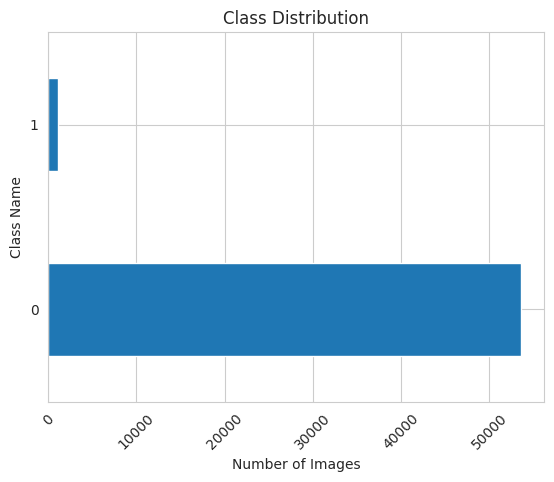

In [22]:
# Create a DataFrame to aid in analysis
df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

# Map numerical labels to class names
#label_to_class = {v: k for k, v in class_to_label.items()}
#df['cancer'] = df['label'].map(label_to_class)

# Display class counts
class_counts = df['label'].value_counts()
print("Class counts:\n", class_counts)

# Plot class distribution
class_counts.plot(kind='barh')
plt.title('Class Distribution')
plt.xlabel('Number of Images')
plt.ylabel('Class Name')
plt.xticks(rotation=45)
plt.show() 



In [18]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [23]:
label_to_class = {0: 'Normal', 1: 'Cancer'}

In [24]:
df.head()

,image_path,label
0,/kaggle/input/rsna-breast-cancer-512-pngs/1000...,0
1,/kaggle/input/rsna-breast-cancer-512-pngs/1000...,0
2,/kaggle/input/rsna-breast-cancer-512-pngs/1000...,0
3,/kaggle/input/rsna-breast-cancer-512-pngs/1000...,0
4,/kaggle/input/rsna-breast-cancer-512-pngs/1001...,0


In [25]:
df.tail()

,image_path,label
54701,/kaggle/input/rsna-breast-cancer-512-pngs/9973...,0
54702,/kaggle/input/rsna-breast-cancer-512-pngs/9989...,0
54703,/kaggle/input/rsna-breast-cancer-512-pngs/9989...,0
54704,/kaggle/input/rsna-breast-cancer-512-pngs/9989...,0
54705,/kaggle/input/rsna-breast-cancer-512-pngs/9989...,0


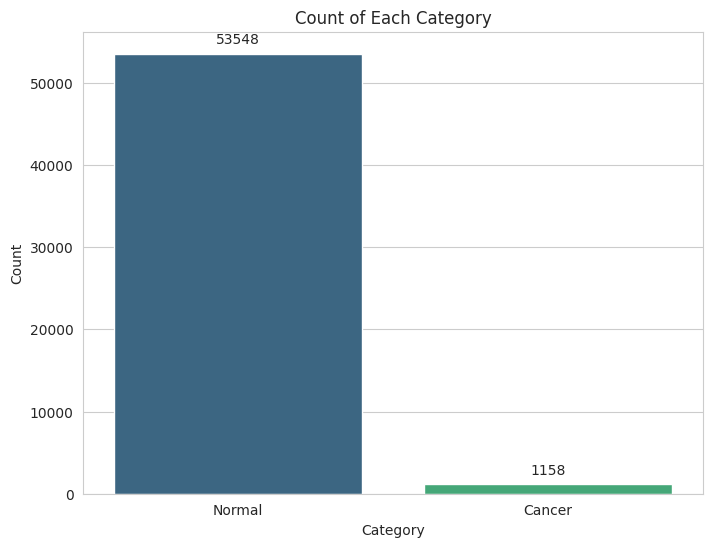

In [26]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

ax = sns.countplot(data=df, x=df['label'].map(label_to_class), palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.title("Count of Each Category")
plt.xlabel("Category")
plt.ylabel("Count")

plt.show()

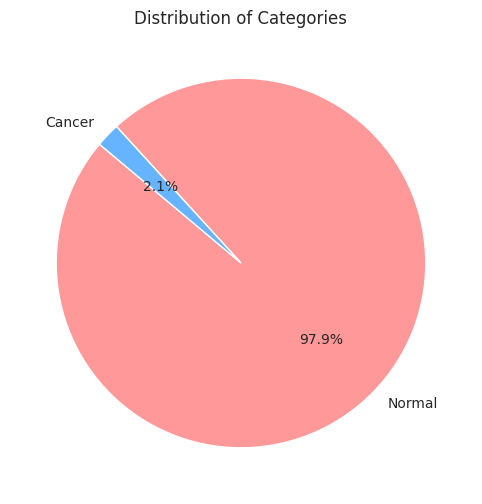

In [27]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=[label_to_class[i] for i in label_counts.index], autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])

plt.title("Distribution of Categories")

plt.show() 

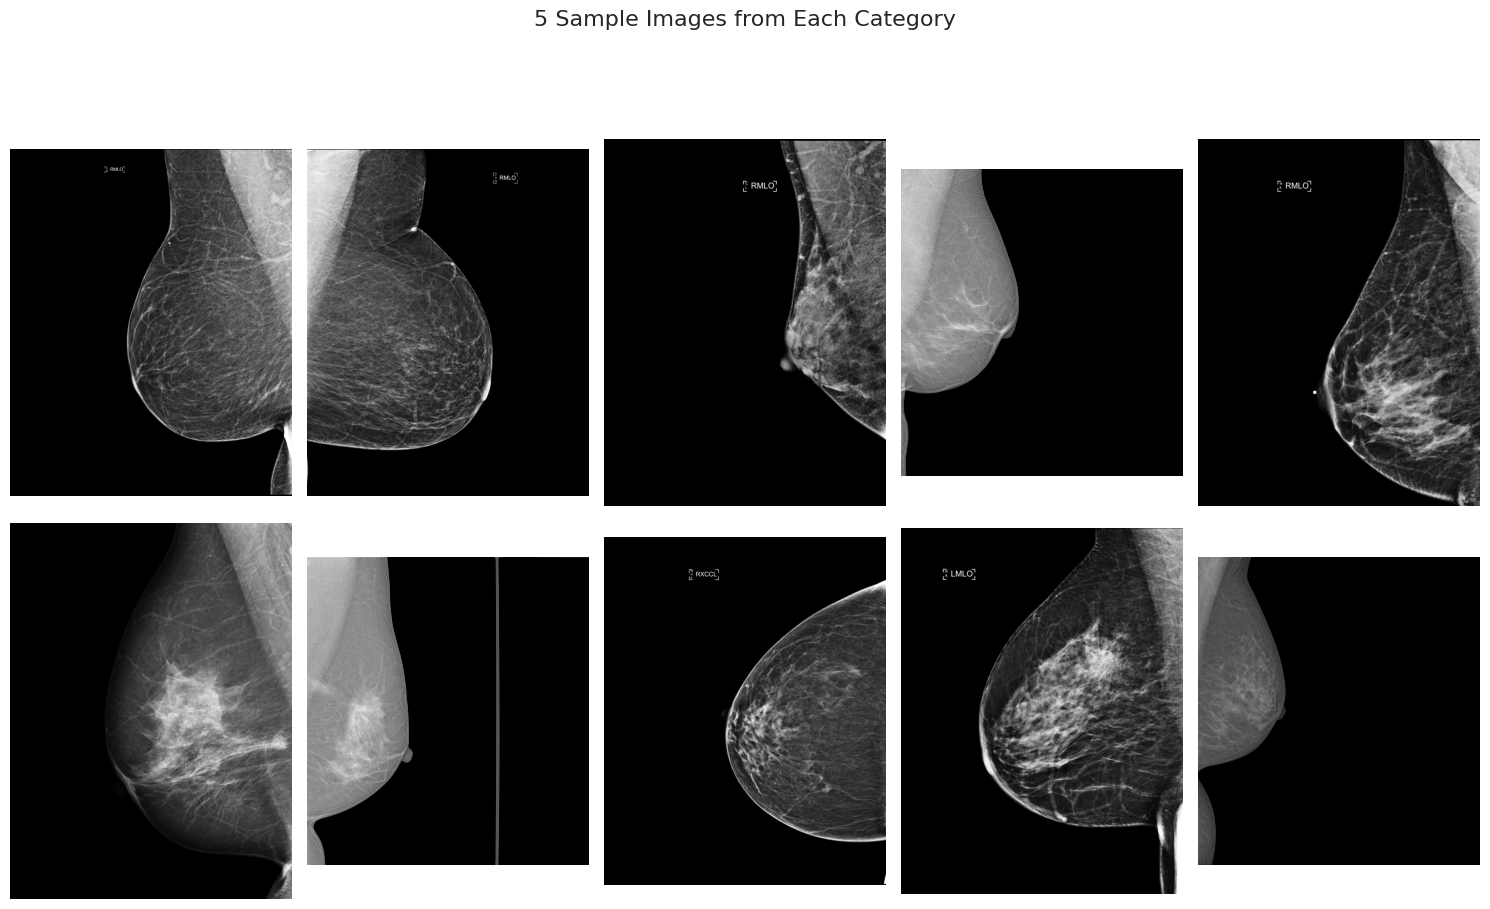

In [ ]:
num_images = 5
fig, axes = plt.subplots(len(label_to_class), num_images, figsize=(15, 10))
fig.suptitle("5 Sample Images from Each Category", fontsize=16)

for i, category in enumerate(label_to_class):
    sample_images = df[df['label'] == category].sample(num_images, random_state=42) # Changed 'label' to 'cancer' based on RSNA columns

    for j, (idx, row) in enumerate(sample_images.iterrows()): # Iterate safely
        image_path = row['image_path'] # Make sure you use the column with the full path
        
        # --- FIX STARTS HERE ---
        # Using dicomsdl to open the image
        dcm = dicomsdl.open(image_path)
        img = dcm.pixelData()
        
        # Optional: Fix inverted colors (Photometric Interpretation)
        info = dcm.getPixelDataInfo()
        if info['PhotometricInterpretation'] == "MONOCHROME1":
            img = np.max(img) - img

        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_ylabel(str(category), fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

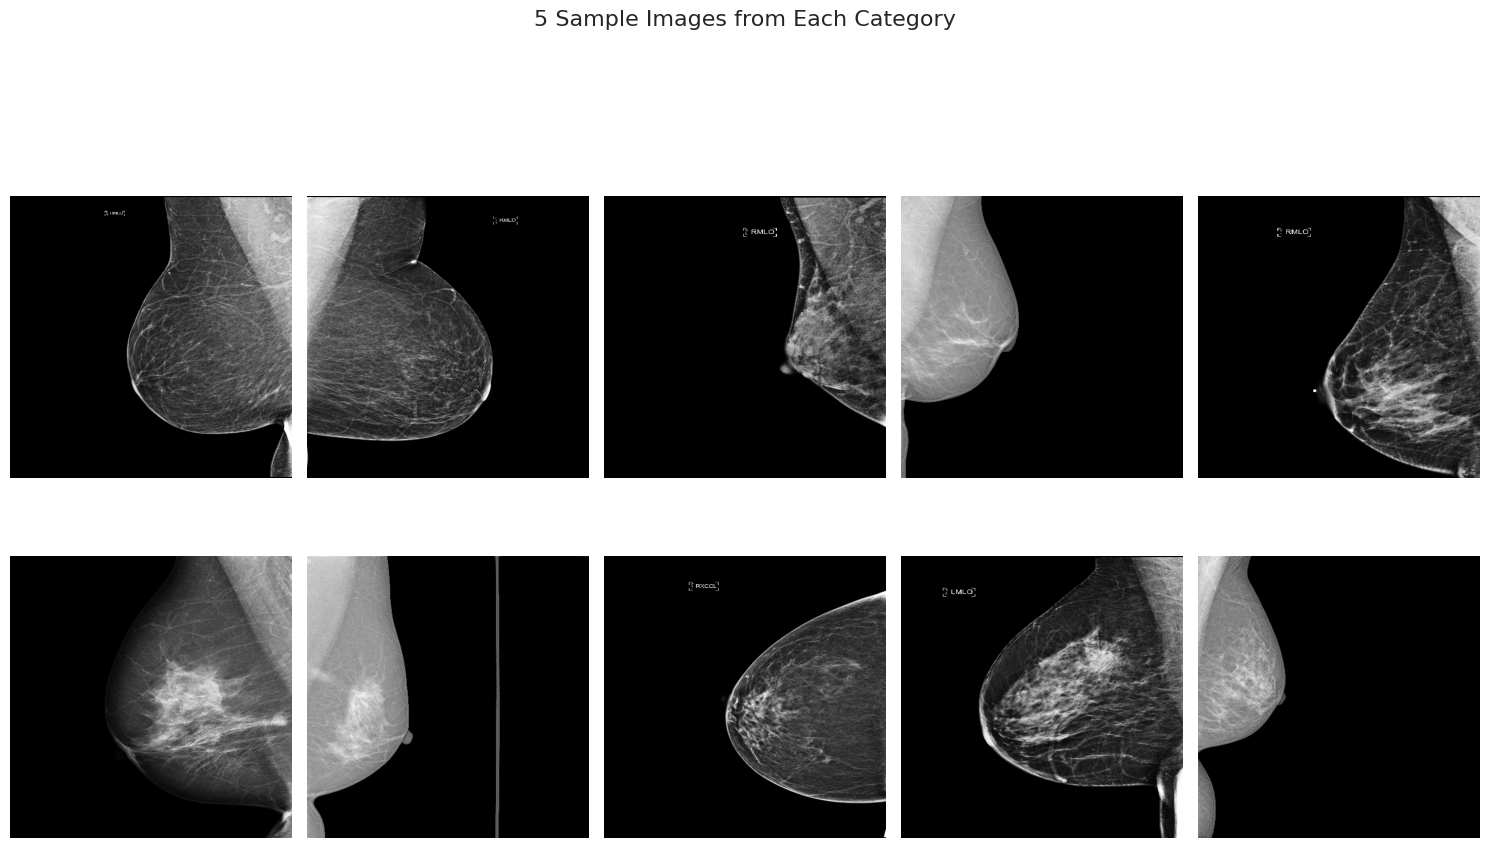

In [28]:
# Display 5 samples from each category 
num_images = 5
fig, axes = plt.subplots(len(label_to_class), num_images, figsize=(15, 10))
fig.suptitle("5 Sample Images from Each Category", fontsize=16)

for i, category in enumerate(label_to_class):
    sample_images = df[df['label'] == category].sample(num_images, random_state=42) # Changed 'label' to 'cancer' based on RSNA columns

    for j, (idx, row) in enumerate(sample_images.iterrows()): # Iterate safely
        image_path = row['image_path'] # Make sure you use the column with the full path
        
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_ylabel(str(category), fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

(-0.5, 511.5, 511.5, -0.5)

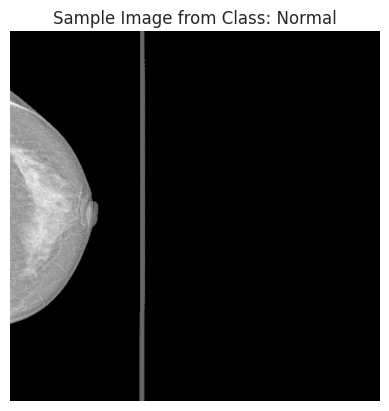

In [29]:
#sample image
sample_path = df.iloc[0]['image_path']
img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)

#show the image
plt.imshow(img, cmap='gray')
plt.title(f"Sample Image from Class: {label_to_class[df.iloc[0]['label']]}")
plt.axis('off')

In [ ]:
import time

def preprocess_dicom_to_png(df, output_dir="processed", target_size=(512, 512), log_every=100):
    os.makedirs(output_dir, exist_ok=True)

    for label in df['label'].unique():
        os.makedirs(os.path.join(output_dir, str(label)), exist_ok=True)

    total = len(df)
    start_time = time.time()

    for idx, row in df.iterrows():
        dcm_path = row["image_path"]
        label = row["label"]

        try:
            # Load DICOM
            dcm = dicomsdl.open_file(dcm_path)
            img = dcm.pixelData().astype(np.float32)

            # Normalize
            img = (img - img.min()) / (img.max() - img.min() + 1e-6)
            img = (img * 255).astype(np.uint8)

            # Resize
            img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

            # Save
            file_name = os.path.basename(dcm_path).replace(".dcm", ".png")
            save_path = os.path.join(output_dir, str(label), file_name)
            Image.fromarray(img_resized).save(save_path)

        except Exception as e:
            print(f"[ERROR] Failed on {dcm_path}: {e}")

        # ---- Progress Log ----
        if (idx + 1) % log_every == 0:
            elapsed = time.time() - start_time
            per_img = elapsed / (idx + 1)
            eta = per_img * (total - idx - 1)

            print(
                f"[{idx + 1}/{total}] processed | "
                f"{per_img:.3f} sec/img | "
                f"ETA: {eta/60:.1f} min"
            )

    print(f"\n✔ Completed. Total time: {(time.time() - start_time)/60:.1f} min")


In [29]:
preprocess_dicom_to_png(df, output_dir="/kaggle/working/processed", target_size=(256, 256))

[100/54706] processed | 0.743 sec/img | ETA: 676.6 min
[200/54706] processed | 0.655 sec/img | ETA: 595.0 min
[300/54706] processed | 0.622 sec/img | ETA: 564.2 min
[400/54706] processed | 0.601 sec/img | ETA: 544.4 min
[500/54706] processed | 0.679 sec/img | ETA: 613.3 min
[600/54706] processed | 0.652 sec/img | ETA: 588.3 min
[700/54706] processed | 0.657 sec/img | ETA: 591.3 min
[800/54706] processed | 0.651 sec/img | ETA: 584.5 min
[900/54706] processed | 0.641 sec/img | ETA: 574.6 min
[1000/54706] processed | 0.637 sec/img | ETA: 570.5 min
[1100/54706] processed | 0.641 sec/img | ETA: 572.2 min
[1200/54706] processed | 0.640 sec/img | ETA: 570.3 min
[1300/54706] processed | 0.629 sec/img | ETA: 560.2 min
[1400/54706] processed | 0.652 sec/img | ETA: 579.1 min
[1500/54706] processed | 0.647 sec/img | ETA: 573.6 min
[1600/54706] processed | 0.656 sec/img | ETA: 580.6 min
[1700/54706] processed | 0.661 sec/img | ETA: 584.4 min
[1800/54706] processed | 0.668 sec/img | ETA: 588.6 min
[

KeyboardInterrupt: 

In [1]:
# know number of images in each folder
import os
for label in ['0', '1']:
    folder_path = os.path.join('/kaggle/working/processed', label)
    num_images = len(os.listdir(folder_path))
    print(f"Number of images in folder {label}: {num_images}")

Number of images in folder 0: 15306
Number of images in folder 1: 312


**4. Data Augmentation for Minority Classes**


In [30]:
# Define augmentation parameters
data_gen_args = dict(
    preprocessing_function=preprocess_input,  # Required for VGG
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [31]:
# Define data augmentation transformations
def balanced_data_generator(df, batch_size, target_size, datagen):
    '''
    A generator that yields batches of images and labels, balancing classes by oversampling minority classes.
    '''
    # Get the class counts
    class_counts = df['label'].value_counts()
    max_count = class_counts.max()
    class_indices = {label: df[df['label'] == label].index for label in class_counts.index}

    while True:
        batch_paths = []
        batch_labels = []

        # Oversample minority classes
        for label, indices in class_indices.items():
            num_samples = max_count - len(indices)
            if num_samples > 0:
                extra_indices = np.random.choice(indices, size=num_samples, replace=True)
                indices = indices.union(extra_indices)

            # Shuffle indices
            indices = np.random.permutation(indices)
            batch_paths.extend(df.loc[indices, 'image_path'].tolist())
            batch_labels.extend(df.loc[indices, 'label'].tolist())

        # Combine and shuffle
        combined = list(zip(batch_paths, batch_labels))
        np.random.shuffle(combined)
        batch_paths, batch_labels = zip(*combined)

        # Yield batches
        for i in range(0, len(batch_paths), batch_size):
            batch_end = min(i + batch_size, len(batch_paths))
            batch_images = []
            batch_labels_one_hot = []

            for j in range(i, batch_end):
                # Load and preprocess the image
                img = Image.open(batch_paths[j]).convert('RGB')
                #img = img.resize(target_size)
                img_array = np.array(img)
                batch_images.append(img_array)
                batch_labels_one_hot.append(to_categorical(batch_labels[j], num_classes=len(classes)))

            # Convert lists to arrays
            X_batch = np.array(batch_images)
            y_batch = np.array(batch_labels_one_hot)

            # Apply real-time data augmentation
            augmented_iterator = datagen.flow(X_batch, y_batch, batch_size=batch_size, shuffle=False)
            X_batch_augmented, y_batch_augmented = next(augmented_iterator)

            # Normalize
            X_batch_augmented = X_batch_augmented / 255.0

            yield X_batch_augmented, y_batch_augmented

**Step 5: Split the Dataset**


In [32]:

# Split into training and temp (validation + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42,
    shuffle = True,
    

)

# Split temp into validation and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42,
    shuffle = True
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 43764
Validation set size: 5471
Test set size: 5471


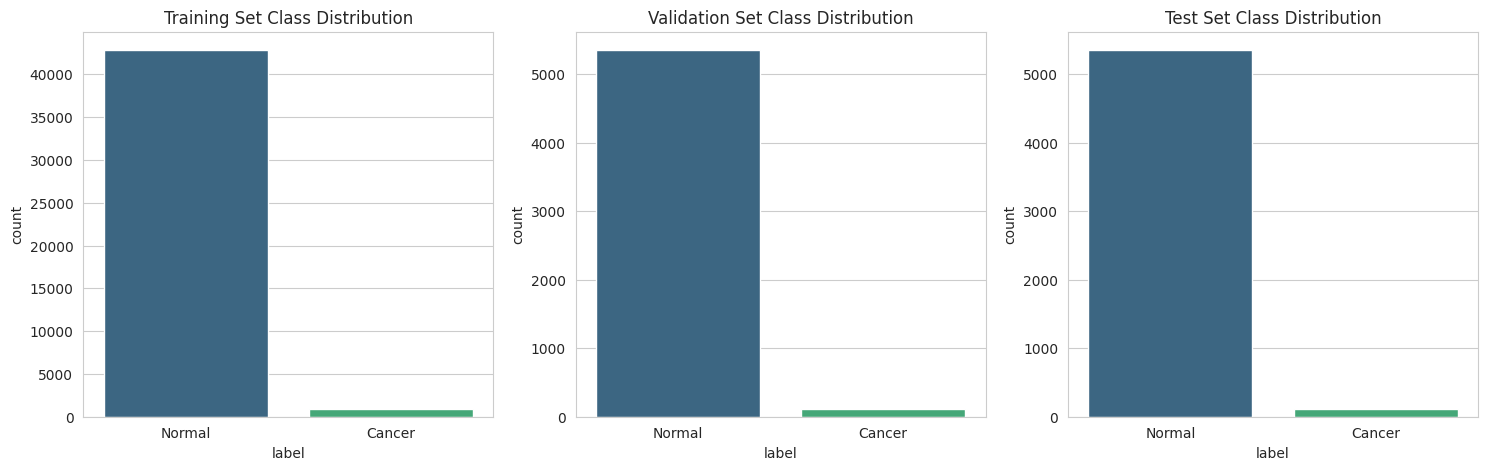

In [39]:
# i want to visualize the 3 sets class distribution side by side and compare them by showing numbers on each column
plt.subplots(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.countplot(data=train_df, x=train_df['label'].map(label_to_class), palette='viridis')
plt.title("Training Set Class Distribution")
plt.subplot(1, 3, 2)
sns.countplot(data=val_df, x=val_df['label'].map(label_to_class), palette='viridis')
plt.title("Validation Set Class Distribution")
plt.subplot(1, 3, 3)
sns.countplot(data=test_df, x=test_df['label'].map(label_to_class), palette='viridis')
plt.title("Test Set Class Distribution")
plt.show()

**6. Preparing Data Generators**


6.1. Training Data Generator


In [82]:
import math

class RSNADataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, x_col, y_col, batch_size=16, target_size=(224, 224), shuffle=True):
        self.df = df
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end() # Shuffle at start

    def __len__(self):
        # Number of batches per epoch
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, index):
        # Generate one batch of data
        # 1. Select indices for the batch
        batch_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        
        # 2. Get the rows
        batch_df = self.df.iloc[batch_indices]
        
        # 3. Generate data
        X, y = self.__data_generation(batch_df)
        return X, y

    def on_epoch_end(self):
        # Update indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_df):
        X = np.empty((len(batch_df), *self.target_size, 3)) # RGB Output
        y = np.empty((len(batch_df)), dtype=int)

        for i, (_, row) in enumerate(batch_df.iterrows()):
            path = row[self.x_col]
            label = row[self.y_col]

            # --- DICOM LOADING LOGIC ---
            try:
                dcm = dicomsdl.open(path)
                img = dcm.pixelData()
                
                # Fix Monochrome
                info = dcm.getPixelDataInfo()
                if info['PhotometricInterpretation'] == "MONOCHROME1":
                    img = np.max(img) - img
                
                # Normalize 0-1
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # Resize
                img = cv2.resize(img, (self.target_size[1], self.target_size[0]))
                
                # Convert Grayscale to RGB (Stack 3 times)
                img = np.stack((img,)*3, axis=-1)
                
                X[i,] = img
                y[i] = label
                
            except Exception as e:
                # Fallback for bad images (return black image)
                print(f"Error loading {path}: {e}")
                X[i,] = np.zeros((*self.target_size, 3))
                y[i] = 0

        return X, y


batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# --- HOW TO USE IT ---
# 1. Initialize
train_gen_new = RSNADataGenerator(
    train_df, 
    x_col='image_path', # This must point to .dcm files
    y_col='label',     # Target column
    batch_size=16,
    target_size=(224, 224)
)

# 2. Train
# model.fit(my_train_gen, epochs=5)

In [43]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])


I0000 00:00:1765225047.320558      86 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [44]:
IMG_SIZE = 512
BATCH_SIZE = 32

def load_and_preprocess(path, label, augment=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    
    if augment:
        image = data_augmentation(image)
        
    return image, label


### Training dataset
Augment only cancer samples:

In [45]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'], train_df['label'])
)

train_ds = train_ds.map(
    lambda x, y: load_and_preprocess(x, y, augment=tf.equal(y, 1)),
    num_parallel_calls=tf.data.AUTOTUNE
).shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


### Validation + Test (NO augmentation)

In [46]:
val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['image_path'], val_df['label'])
).map(load_and_preprocess).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['image_path'], test_df['label'])
).map(load_and_preprocess).batch(BATCH_SIZE)


### Add Class Weights

In [48]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights = {i: weights[i] for i in range(len(weights))}
class_weights


{0: 0.5108081609785704, 1: 23.630669546436284}

### Simple CNN or Transfer Learning

Because our images are 512×512, we should use transfer learning.

Best choices for medical grayscale images:

- EfficientNetB0/B3

- ResNet50

- MobileNetV3 Large

In [52]:
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(512, 512, 1),
    weights=None  # No ImageNet weights (medical grayscale)
)

model = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [53]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 16, 16, 1280)   │     4,048,991 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,088 (16.07 MB)

 Trainable params: 4,171,069 (15.91 MB)

 Non-trainable params: 42,019 (164.14 KB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC()]
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights
) 

Epoch 1/20


I0000 00:00:1765226142.179486     174 service.cc:148] XLA service 0x7c4cc002a9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765226142.180954     174 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765226147.411013     174 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1765226163.988631     174 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765226164.194211     174 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765226164.651373     174 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765226164.8572

1367/1368 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.6098 - auc: 0.7729 - loss: 0.5524

E0000 00:00:1765226906.201527     175 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765226906.404468     175 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765226906.810993     175 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765226907.014685     175 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765226907.570729     175 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1368/1368 ━━━━━━━━━━━━━━━━━━━━ 856s 562ms/step - accuracy: 0.6100 - auc: 0.7731 - loss: 0.5522 - val_accuracy: 0.8225 - val_auc: 0.4476 - val_loss: 0.4125
Epoch 2/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 685s 494ms/step - accuracy: 0.9188 - auc: 0.9846 - loss: 0.1563 - val_accuracy: 0.6708 - val_auc: 0.4673 - val_loss: 1.3296
Epoch 3/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 687s 496ms/step - accuracy: 0.9246 - auc: 0.9853 - loss: 0.1627 - val_accuracy: 0.8671 - val_auc: 0.4402 - val_loss: 0.3960
Epoch 4/20
  79/1368 ━━━━━━━━━━━━━━━━━━━━ 11:18 527ms/step - accuracy: 0.9352 - auc: 0.9600 - loss: 0.0794

In [47]:
#check gpu
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

GPU: Tesla P100-PCIE-16GB


**9. Building and Configuring the VGG Model**

In [89]:
inputs = tf.keras.Input(shape=(224, 224, 3), name='input')

conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, name='conv1')(inputs)
maxpool1 = tf.keras.layers.MaxPooling2D(name='maxpool1')(conv1)

conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, name='conv2')(maxpool1)
maxpool2 = tf.keras.layers.MaxPooling2D(name='maxpool2')(conv2)

conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, name='conv3')(maxpool2)
maxpool3 = tf.keras.layers.MaxPooling2D(name='maxpool3')(conv3)

avgpool = tf.keras.layers.GlobalAveragePooling2D(name='avgpool')(maxpool3)

outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(avgpool)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()
#tf.keras.utils.plot_model(model)



Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling2D)         │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3 (MaxPooling2D)         │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool                         │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649 (92.38 KB)

 Trainable params: 23,649 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
#tf.keras.losses.binary_crossentropy
model.compile(optimizer= 'adam' , loss=  tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', 'AUC','loss']) 

In [91]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,
)

callbacks = [early_stopping, reduce_lr]

In [93]:
#steps_per_epoch = len(train_df) * 2 // batch_size  # Oversampling will effectively double the data
# Train the model
history = model.fit(
    train_gen_new,
    #steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data= valid_gen_new,  #(X_val, y_val),
    #class_weight=class_weights,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/20


I0000 00:00:1764459441.330796     264 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2736 ━━━━━━━━━━━━━━━━━━━━ 15:36:08 21s/step - AUC: 0.0000e+00 - accuracy: 0.8125 - loss: 0.6867

I0000 00:00:1764459443.689772     264 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  48/2736 ━━━━━━━━━━━━━━━━━━━━ 7:56:16 11s/step - AUC: 0.4789 - accuracy: 0.9645 - loss: 0.2752

KeyboardInterrupt: 

Step 8: Testing model            


In [74]:
# Saving training history in a dataframe format
history_df = pd.DataFrame(history.history)

# Save to CSV
history_df.to_csv('training_history_3.csv', index=False)

print("Training history saved to 'training_history_3.csv'")

Training history saved to 'training_history_3.csv'


In [75]:
# Concatinating the history of the model
hist_1 = pd.read_csv('/kaggle/working/training_history_1.csv')
hist_2 = pd.read_csv('/kaggle/working/training_history_2.csv')
hist_3 = pd.read_csv('/kaggle/working/training_history_3.csv')


total_hist = pd.concat([hist_1,hist_2,hist_3],axis=0).reset_index()
total_hist

,index,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0,0.748475,0.536194,0.739100,0.529999,0.001
1,1,0.762057,0.520169,0.751211,0.507632,0.001
2,2,0.770059,0.505175,0.793426,0.488158,0.001
3,3,0.791514,0.471505,0.813841,0.447941,0.001
4,4,0.813573,0.439865,0.829412,0.415975,0.001
...,...,...,...,...,...,...
65,15,0.917384,0.211796,0.898616,0.269071,0.001
66,16,0.919114,0.209203,0.897578,0.277473,0.001
67,17,0.917341,0.209858,0.903114,0.262546,0.001
68,18,0.919503,0.208540,0.906920,0.252262,0.001


In [76]:
# Evaluate the model on the test set
test_steps = len(test_df) // batch_size
test_loss, test_accuracy = model.evaluate(test_gen_new, steps=test_steps)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9090 - loss: 0.2330
Test Accuracy: 90.73%


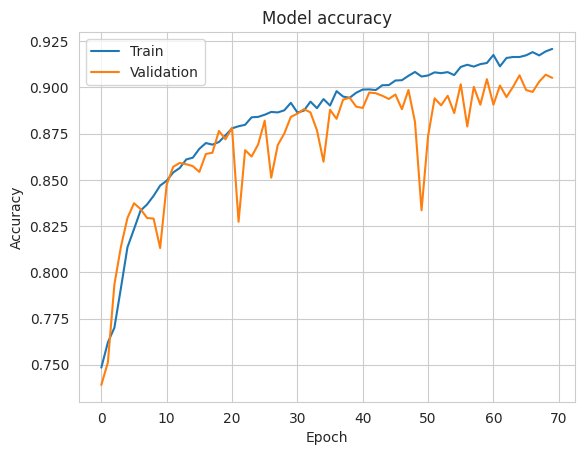

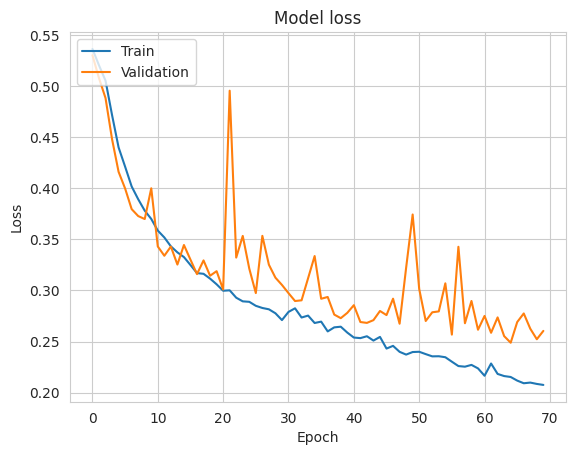

In [77]:
plt.plot(total_hist['accuracy'])
plt.plot(total_hist['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(total_hist['loss'])
plt.plot(total_hist['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [82]:
test_labels = test_gen_new.classes
predictions = model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)
     

report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)
     


181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step
              precision    recall  f1-score   support

  non-tumour       0.91      0.92      0.91      1538
      tumour       0.90      0.90      0.90      1352

    accuracy                           0.91      2890
   macro avg       0.91      0.91      0.91      2890
weighted avg       0.91      0.91      0.91      2890



In [83]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

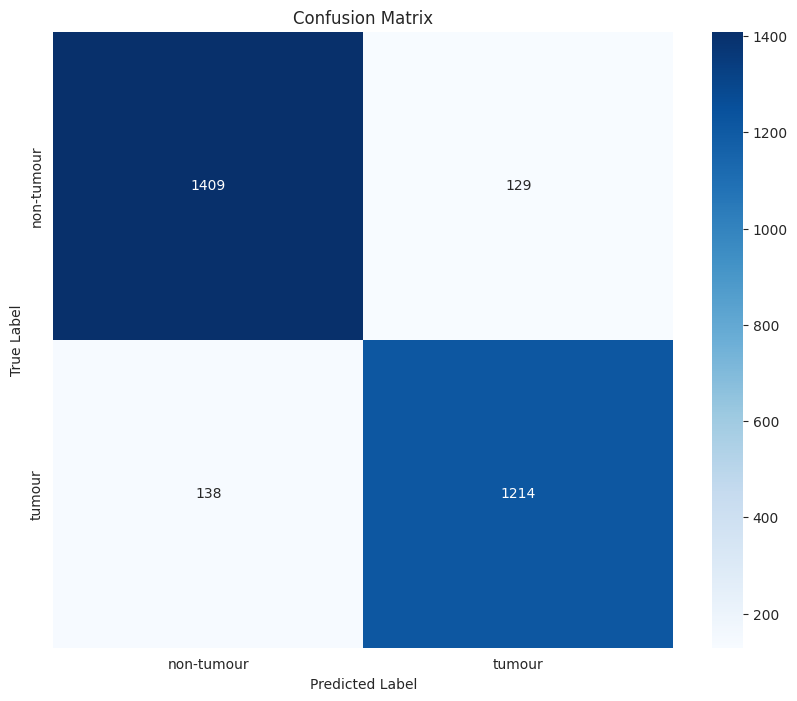

In [84]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()